In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

In [ ]:
np.random.seed(48) #Setting a seed for reproducibility

In [ ]:
PowerData = 'classData.csv'

In [ ]:
try:
  df = pd.read_csv(PowerData)
except FileNotFoundError:
  print(f"Error loading data from {PowerData}")

In [ ]:
#Data Cleaning
print(df.head())
missing = df.isnull().sum().sum()
if missing == 0:
    print("  No missing values")
else:
    print(f" Found {missing} missing values")
    print(df.isnull().sum())

   G  C  B  A          Ia          Ib          Ic        Va        Vb  \
0  1  0  0  1 -151.291812   -9.677452   85.800162  0.400750 -0.132935   
1  1  0  0  1 -336.186183  -76.283262   18.328897  0.312732 -0.123633   
2  1  0  0  1 -502.891583 -174.648023  -80.924663  0.265728 -0.114301   
3  1  0  0  1 -593.941905 -217.703359 -124.891924  0.235511 -0.104940   
4  1  0  0  1 -643.663617 -224.159427 -132.282815  0.209537 -0.095554   

         Vc  
0 -0.267815  
1 -0.189099  
2 -0.151428  
3 -0.130570  
4 -0.113983  
  ✓ No missing values


In [ ]:
# Distinguish between Features and labels
# Features: Ia, Ib, Ic, Va, Vb, Vc (6 sensor measurements)
feature_columns = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
X = df[feature_columns].values

# Labels: G, C, B, A (4-bit fault encoding)
label_columns = ['G', 'C', 'B', 'A']
y_multi = df[label_columns].values

print(f"\nFeatures extracted: {X.shape}")
print(f"  - {X.shape[0]} samples")
print(f"  - {X.shape[1]} features: {feature_columns}")

print(f"\nLabels extracted: {y_multi.shape}")
print(f"  - Multi-label format (G, C, B, A)")


Features extracted: (7861, 6)
  - 7861 samples
  - 6 features: ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

Labels extracted: (7861, 4)
  - Multi-label format (G, C, B, A)


In [ ]:
#Neural networks work better with single-label classifications
#Converting the multi-label fault encoding into a single label classification
def encode_fault_type(row):
    """
    Convert [G, C, B, A] to a single class number.

    Fault type mapping:
    [0,0,0,0] → 0 (No Fault)
    [1,0,0,1] → 1 (LG - Line to Ground)
    [0,1,1,0] → 2 (LL - Line to Line)
    [1,0,1,1] → 3 (LLG - Line to Line to Ground)
    [0,1,1,1] → 4 (LLL - Three Phase)
    [1,1,1,1] → 5 (LLLG - Three Phase with Ground)
    """
    # Convert to tuple for dictionary lookup
    key = tuple(row)

    fault_map = {
        (0, 0, 0, 0): 0,  # No Fault
        (1, 0, 0, 1): 1,  # LG
        (0, 1, 1, 0): 2,  # LL
        (1, 0, 1, 1): 3,  # LLG
        (0, 1, 1, 1): 4,  # LLL
        (1, 1, 1, 1): 5   # LLLG
    }

    return fault_map.get(key, -1)  # Return -1 if unknown pattern

# Apply encoding
y = np.array([encode_fault_type(row) for row in y_multi])

# Create label names for visualization
fault_names = {
    0: "No Fault",
    1: "LG (Line-Ground)",
    2: "LL (Line-Line)",
    3: "LLG (Line-Line-Ground)",
    4: "LLL (Three-Phase)",
    5: "LLLG (Three-Phase-Ground)"
}

print("\nLabel encoding complete!")
print("\nFault type distribution:")

unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    percentage = (count / len(y)) * 100
    if label == -1:
        print(f"  {'UNKNOWN PATTERN':25s} → {count:4d} samples ({percentage:5.2f}%) ")
    else:
        print(f"  {fault_names[label]:25s} → {count:4d} samples ({percentage:5.2f}%)")
if -1 in y:
    unknown_count = np.sum(y == -1)
    print(f"\nWARNING: Found {unknown_count} samples with unknown fault patterns!")
    print("These patterns don't match any expected fault types.")
    print("Please check your CSV for these [G,C,B,A] combinations:")

    # Show which patterns are unknown
    unknown_indices = np.where(y == -1)[0]
    unknown_patterns = y_multi[unknown_indices]
    unique_unknown = np.unique(unknown_patterns, axis=0)

    for pattern in unique_unknown[:5]:  # Show first 5 unique unknown patterns
        print(f"  [G={pattern[0]}, C={pattern[1]}, B={pattern[2]}, A={pattern[3]}]")


Label encoding complete!

Fault type distribution:
  No Fault                  → 2365 samples (30.09%)
  LG (Line-Ground)          → 1129 samples (14.36%)
  LL (Line-Line)            → 1004 samples (12.77%)
  LLG (Line-Line-Ground)    → 1134 samples (14.43%)
  LLL (Three-Phase)         → 1096 samples (13.94%)
  LLLG (Three-Phase-Ground) → 1133 samples (14.41%)


In [ ]:
print("\n🔍 Analyzing all [G,C,B,A] patterns in your CSV:")
label_combinations = df[['G', 'C', 'B', 'A']].values
unique_patterns = np.unique(label_combinations, axis=0)

print(f"Found {len(unique_patterns)} unique patterns:")
for pattern in unique_patterns:
    count = np.sum((label_combinations == pattern).all(axis=1))
    print(f"  [{pattern[0]}, {pattern[1]}, {pattern[2]}, {pattern[3]}] → {count} samples")


🔍 Analyzing all [G,C,B,A] patterns in your CSV:
Found 6 unique patterns:
  [0, 0, 0, 0] → 2365 samples
  [0, 1, 1, 0] → 1004 samples
  [0, 1, 1, 1] → 1096 samples
  [1, 0, 0, 1] → 1129 samples
  [1, 0, 1, 1] → 1134 samples
  [1, 1, 1, 1] → 1133 samples


In [ ]:
# STEP 4: SPLIT DATA INTO TRAIN/VALIDATION/TEST
print("SPLITTING DATA (70% Train / 15% Validation / 15% Test)")
# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y  # Keep same fault distribution in all splits
)

SPLITTING DATA (70% Train / 15% Validation / 15% Test)


In [ ]:
# Split the rest (validation[15%] and training data[70%] )
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,  # 0.176 * 85% ≈ 15% of original
    random_state=42,
    stratify=y_temp
)
print(f"\nData split complete:")
print(f"  Training:   {X_train.shape[0]:4d} samples ({X_train.shape[0]/X.shape[0]*100:5.1f}%)")
print(f"  Validation: {X_val.shape[0]:4d} samples ({X_val.shape[0]/X.shape[0]*100:5.1f}%)")
print(f"  Test:       {X_test.shape[0]:4d} samples ({X_test.shape[0]/X.shape[0]*100:5.1f}%)")




Data split complete:
  Training:   5505 samples ( 70.0%)
  Validation: 1176 samples ( 15.0%)
  Test:       1180 samples ( 15.0%)


In [ ]:
# Verify stratification worked
print("\n Verifying balanced splits:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    print(f"\n  {split_name} set distribution:")
    unique, counts = np.unique(y_split, return_counts=True)
    for label, count in zip(unique, counts):
        percentage = (count / len(y_split)) * 100
        print(f"    Class {label}: {count:3d} samples ({percentage:5.1f}%)")


 Verifying balanced splits:

  Train set distribution:
    Class 0: 1656 samples ( 30.1%)
    Class 1: 791 samples ( 14.4%)
    Class 2: 703 samples ( 12.8%)
    Class 3: 794 samples ( 14.4%)
    Class 4: 767 samples ( 13.9%)
    Class 5: 794 samples ( 14.4%)

  Val set distribution:
    Class 0: 354 samples ( 30.1%)
    Class 1: 169 samples ( 14.4%)
    Class 2: 150 samples ( 12.8%)
    Class 3: 170 samples ( 14.5%)
    Class 4: 164 samples ( 13.9%)
    Class 5: 169 samples ( 14.4%)

  Test set distribution:
    Class 0: 355 samples ( 30.1%)
    Class 1: 169 samples ( 14.3%)
    Class 2: 151 samples ( 12.8%)
    Class 3: 170 samples ( 14.4%)
    Class 4: 165 samples ( 14.0%)
    Class 5: 170 samples ( 14.4%)


In [ ]:
print("NORMALIZING FEATURES (Standardization)")
print("\nBefore normalization (training data):")
print(f"  Mean: {X_train.mean(axis=0)}")
print(f"  Std:  {X_train.std(axis=0)}")

# Create scaler and fit ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test using the SAME scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n After normalization (training data):")
print(f"  Mean: {X_train_scaled.mean(axis=0)}")
print(f"  Std:  {X_train_scaled.std(axis=0)}")
print("\n Features normalized to mean≈0, std≈1")

NORMALIZING FEATURES (Standardization)

Before normalization (training data):
  Mean: [ 1.45299653e+01 -4.35587135e+01  3.42742989e+01 -1.04368335e-02
  4.24757819e-03  6.18925537e-03]
  Std:  [4.67551620e+02 4.40023596e+02 3.69951207e+02 2.87744092e-01
 3.12836515e-01 3.08928888e-01]

 After normalization (training data):
  Mean: [ 8.03071405e-17  4.95818948e-17  8.60221169e-17 -6.07773999e-17
  1.00030994e-17  4.99751618e-17]
  Std:  [1. 1. 1. 1. 1. 1.]

 Features normalized to mean≈0, std≈1



✓ Visualization saved as 'fault_patterns.png'


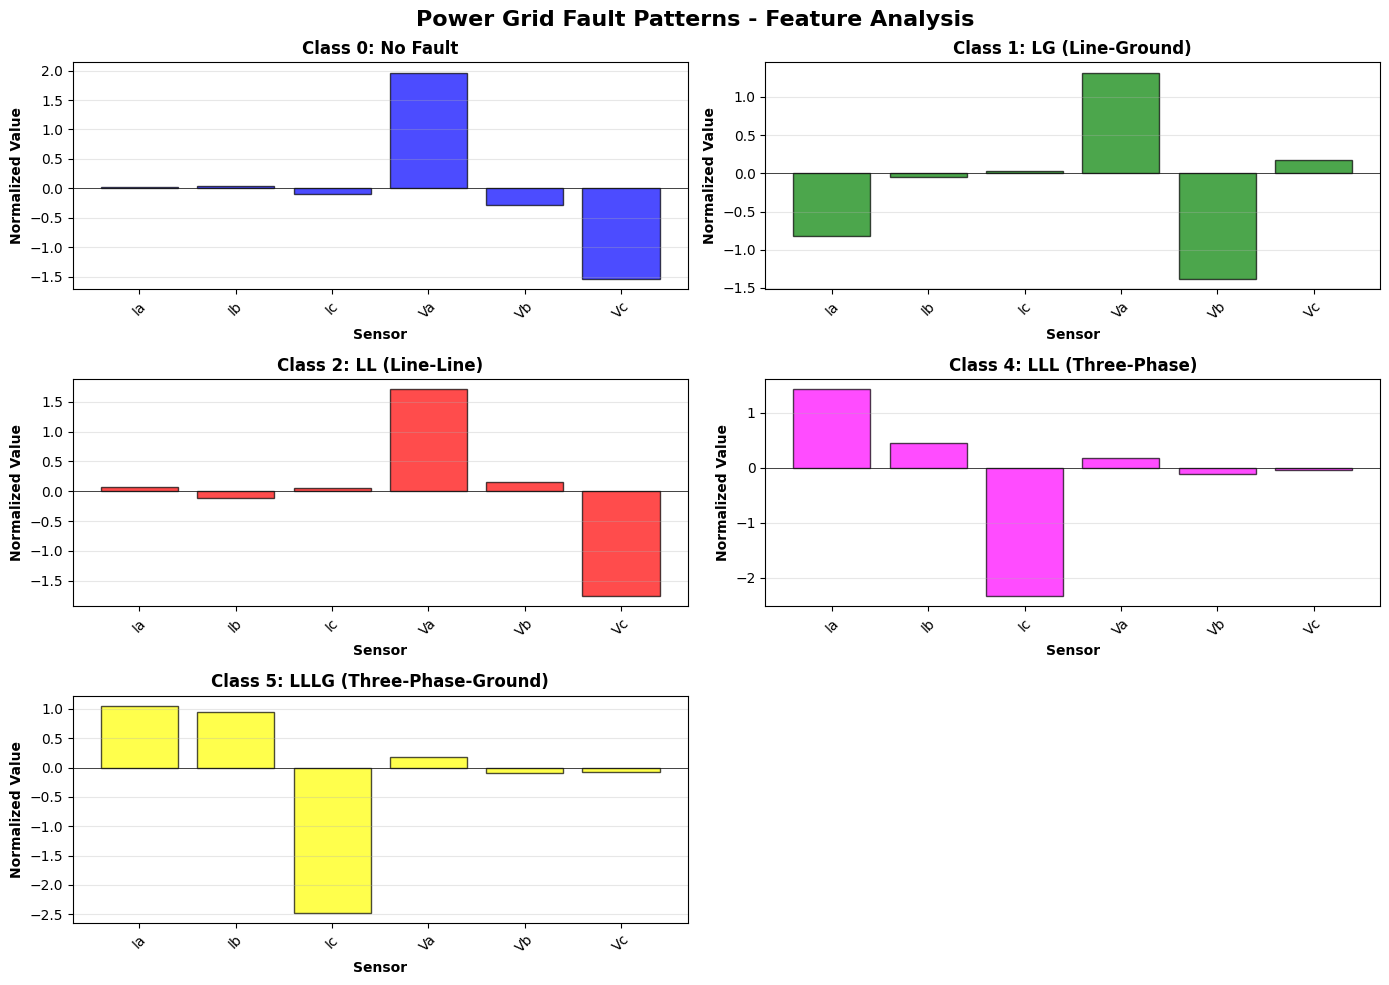


📊 Creating feature correlation heatmap...
✓ Correlation heatmap saved as 'feature_correlation.png'


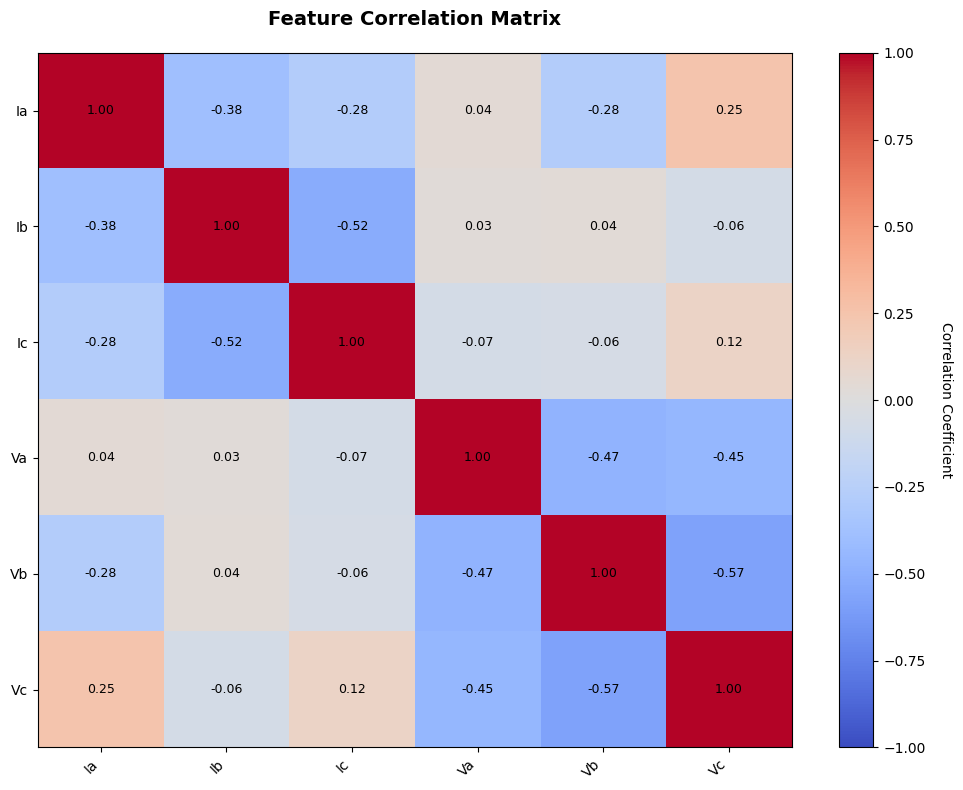

In [ ]:
#Visualizing Data
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Power Grid Fault Patterns - Feature Analysis', fontsize=16, fontweight='bold')

# Visualize each fault type
fault_types_to_plot = [0, 1, 2, 4, 5]  # Select interesting fault types
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

for idx, fault_class in enumerate(fault_types_to_plot[:6]):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    # Get first sample of this fault type
    sample_indices = np.where(y_train == fault_class)[0]

    if len(sample_indices) > 0:
        sample = X_train_scaled[sample_indices[0]]

        # Create bar plot
        x_pos = np.arange(len(feature_columns))
        bars = ax.bar(x_pos, sample, color=colors[fault_class], alpha=0.7, edgecolor='black')

        ax.set_xlabel('Sensor', fontweight='bold')
        ax.set_ylabel('Normalized Value', fontweight='bold')
        ax.set_title(f'Class {fault_class}: {fault_names[fault_class]}', fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(feature_columns, rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    else:
        ax.text(0.5, 0.5, 'No samples', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Class {fault_class}: {fault_names[fault_class]}', fontweight='bold')

# Remove empty subplot if odd number
if len(fault_types_to_plot) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.savefig('fault_patterns.png', dpi=150, bbox_inches='tight')
print("\n Visualization saved as 'fault_patterns.png'")
plt.show()

# Create correlation heatmap
print("\n Creating feature correlation heatmap...")
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate correlation matrix
correlation_matrix = np.corrcoef(X_train_scaled.T)

# Plot heatmap
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(np.arange(len(feature_columns)))
ax.set_yticks(np.arange(len(feature_columns)))
ax.set_xticklabels(feature_columns, rotation=45, ha='right')
ax.set_yticklabels(feature_columns)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# Add correlation values as text
for i in range(len(feature_columns)):
    for j in range(len(feature_columns)):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('feature_correlation.png', dpi=150, bbox_inches='tight')
print(" Correlation heatmap saved as 'feature_correlation.png'")
plt.show()

In [ ]:
#Saving Preprocessed data

print("SAVING PROCESSED DATA")

# Save datasets
np.save('X_train.npy', X_train_scaled)
np.save('X_val.npy', X_val_scaled)
np.save('X_test.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

print("\n Saved normalized data:")
print("  - X_train.npy, y_train.npy")
print("  - X_val.npy, y_val.npy")
print("  - X_test.npy, y_test.npy")

# Save metadata
import pickle

metadata = {
    'feature_columns': feature_columns,
    'fault_names': fault_names,
    'scaler': scaler,
    'num_classes': len(fault_names),
    'input_shape': (len(feature_columns),),
    'class_distribution': dict(zip(*np.unique(y, return_counts=True)))
}

with open('dataset_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(" Saved metadata: dataset_metadata.pkl")

SAVING PROCESSED DATA

✓ Saved normalized data:
  - X_train.npy, y_train.npy
  - X_val.npy, y_val.npy
  - X_test.npy, y_test.npy
✓ Saved metadata: dataset_metadata.pkl


In [ ]:
print("SAVING PROCESSED DATA AS CSV")

# Convert NumPy arrays to DataFrames and save as CSV
pd.DataFrame(X_train_scaled).to_csv('X_train.csv', index=False)
pd.DataFrame(X_val_scaled).to_csv('X_val.csv', index=False)
pd.DataFrame(X_test_scaled).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_val).to_csv('y_val.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

print("\n Saved normalized data as CSV files:")
print("  - X_train.csv, y_train.csv")
print("  - X_val.csv, y_val.csv")
print("  - X_test.csv, y_test.csv")

SAVING PROCESSED DATA AS CSV

✓ Saved normalized data as CSV files:
  - X_train.csv, y_train.csv
  - X_val.csv, y_val.csv
  - X_test.csv, y_test.csv


Creating the Neural Network

In [ ]:
#Creating the Nueral network
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle

In [ ]:
# Training parameters
EPOCHS = 50              # How many times to see all training data
BATCH_SIZE = 32          # How many samples to process at once
LEARNING_RATE = 0.001    # How fast the model learns (smaller = more careful)
try:
    # Load training data
    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')

    # Load validation data
    X_val = np.load('X_val.npy')
    y_val = np.load('y_val.npy')

    # Load test data
    X_test = np.load('X_test.npy')
    y_test = np.load('y_test.npy')

    # Load metadata
    with open('dataset_metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)

    print(f"\n Data loaded successfully!")
    print(f"  Training:   {X_train.shape[0]} samples")
    print(f"  Validation: {X_val.shape[0]} samples")
    print(f"  Test:       {X_test.shape[0]} samples")
    print(f"  Features:   {X_train.shape[1]} (normalized)")
    print(f"  Classes:    {metadata['num_classes']}")

except FileNotFoundError as e:
    print(f"\n Error: Could not find preprocessed data files!")
    print("Please run the data loader script first (load_data.py)")
    exit()

# Extract metadata
num_classes = metadata['num_classes']
fault_names = metadata['fault_names']
feature_columns = metadata['feature_columns']


 Data loaded successfully!
  Training:   5505 samples
  Validation: 1176 samples
  Test:       1180 samples
  Features:   6 (normalized)
  Classes:    6


In [ ]:
#Building the model
def build_deep_model(input_shape, num_classes):
    """
    Deep Neural Network (More capacity)

    Architecture:
    Input → Dense(128) → Dropout → Dense(64) → Dropout → Dense(32) → Output

    New concepts:
    - More layers = Can learn more complex patterns
    - Dropout = Randomly ignore some neurons during training
      (Prevents overfitting - like studying with random distractions
       to make sure you really understand, not just memorize)
    - BatchNormalization = Stabilizes learning
    """
    model = keras.Sequential([
        # First hidden layer (larger)
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),  # Normalize activations
        layers.Dropout(0.3),           # Drop 30% of neurons randomly

        # Second hidden layer
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Third hidden layer
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),           # Less dropout in deeper layers

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
# Build selected model
input_shape = (X_train.shape[1],)  # (6,) for 6 features

model = build_deep_model(input_shape, num_classes)
print("\n📋 Model Architecture:")
model.summary()


📋 Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,198 (47.65 KB)

 Trainable params: 11,814 (46.15 KB)

 Non-trainable params: 384 (1.50 KB)

 COMPILE MODEL

In [ ]:
"""
Compilation configures the learning process:

1. Optimizer: How the model updates its weights
   - 'adam': Adaptive learning rate (smart and popular)
   - Like having a smart tutor who adjusts teaching speed

2. Loss Function: How to measure errors
   - 'sparse_categorical_crossentropy': For integer labels (0,1,2,3,4,5)
   - Measures how wrong predictions are

3. Metrics: What to track during training
   - 'accuracy': Percentage of correct predictions
"""

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',  # For integer labels
    metrics=['accuracy']
)

print(" Model compiled with:")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss: Sparse Categorical Crossentropy")
print(f"  Metrics: Accuracy")


 Model compiled with:
  Optimizer: Adam (lr=0.001)
  Loss: Sparse Categorical Crossentropy
  Metrics: Accuracy


In [ ]:
#Setting up Callback

"""
Callbacks: Actions to perform during training

1. EarlyStopping: Stop if validation accuracy stops improving
   - Prevents overfitting
   - Like stopping study when practice test scores plateau

2. ModelCheckpoint: Save best model version
   - Saves model when validation accuracy improves
   - Can recover best version if training goes too long

3. ReduceLROnPlateau: Reduce learning rate if stuck
   - Makes smaller adjustments when progress slows
   - Like studying more carefully when material gets harder
"""

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',      # Watch validation accuracy
        patience=10,                 # Wait 10 epochs before stopping
        restore_best_weights=True,   # Load best weights at end
        verbose=1
    ),

    keras.callbacks.ModelCheckpoint(
        'best_model.keras',          # Save to this file
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                  # Reduce LR by half
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

TRAIN MODEL

In [ ]:
print(f"\nTraining for up to {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {len(X_train)}")
print(f"Batches per epoch: {len(X_train) // BATCH_SIZE}")
print("\nStarting training...\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1  # Show progress bar
)

print("\n Training complete!")


Training for up to 50 epochs...
Batch size: 32
Training samples: 5505
Batches per epoch: 172

Starting training...

Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3614 - loss: 1.7271
Epoch 1: val_accuracy improved from -inf to 0.67262, saving model to best_model.keras
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3620 - loss: 1.7250 - val_accuracy: 0.6726 - val_loss: 1.2252 - learning_rate: 0.0010
Epoch 2/50
170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6365 - loss: 0.9071
Epoch 2: val_accuracy improved from 0.67262 to 0.75935, saving model to best_model.keras
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6368 - loss: 0.9059 - val_accuracy: 0.7594 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 3/50
164/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6985 - loss: 0.7168
Epoch 3: val_accuracy improved from 0.75935 to 0.80017, saving model to best_model.keras
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6987 - loss: 0.7152 

In [ ]:
print("\n" + "="*70)
print("EVALUATING MODEL PERFORMANCE")
print("="*70)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n Test Set Performance:")
print(f"  Loss:     {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy*100:.2f}%")

# Get predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Detailed classification report
print("\n Detailed Classification Report:")
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=[fault_names[i] for i in range(num_classes)],
    digits=3))


EVALUATING MODEL PERFORMANCE

📊 Test Set Performance:
  Loss:     0.2687
  Accuracy: 83.98%

📋 Detailed Classification Report:
                           precision    recall  f1-score   support

                 No Fault      0.989     0.997     0.993       355
         LG (Line-Ground)      0.908     0.988     0.946       169
           LL (Line-Line)      0.987     0.987     0.987       151
   LLG (Line-Line-Ground)      0.925     0.947     0.936       170
        LLL (Three-Phase)      0.519     0.824     0.637       165
LLLG (Three-Phase-Ground)      0.471     0.141     0.217       170

                 accuracy                          0.840      1180
                macro avg      0.800     0.814     0.786      1180
             weighted avg      0.827     0.840     0.816      1180




CREATING VISUALIZATIONS
✓ Saved: training_history.png
✓ Saved: confusion_matrix.png


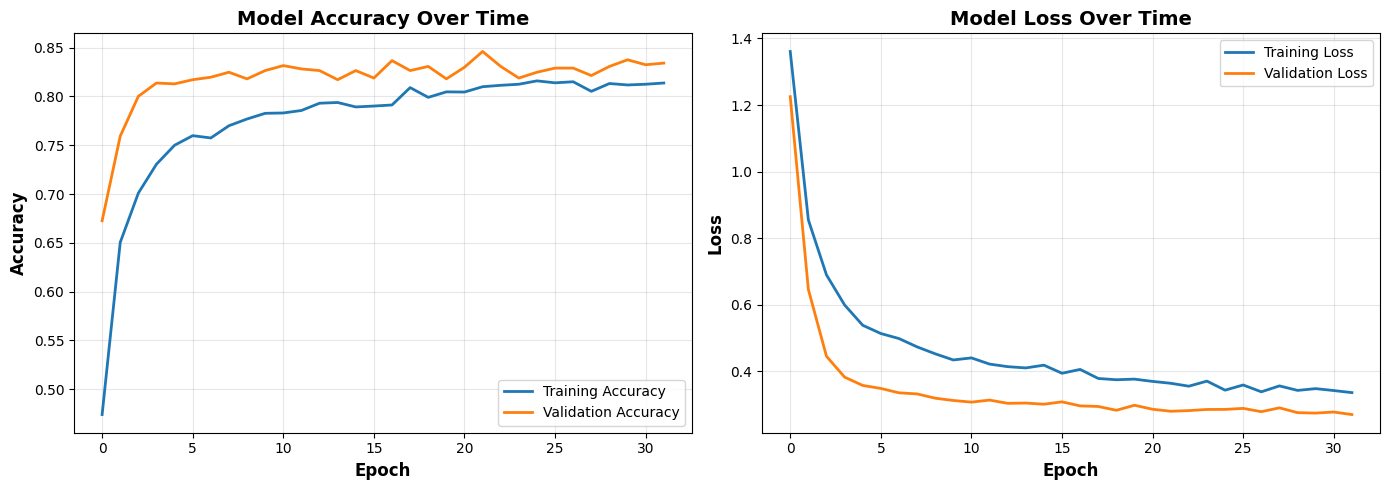

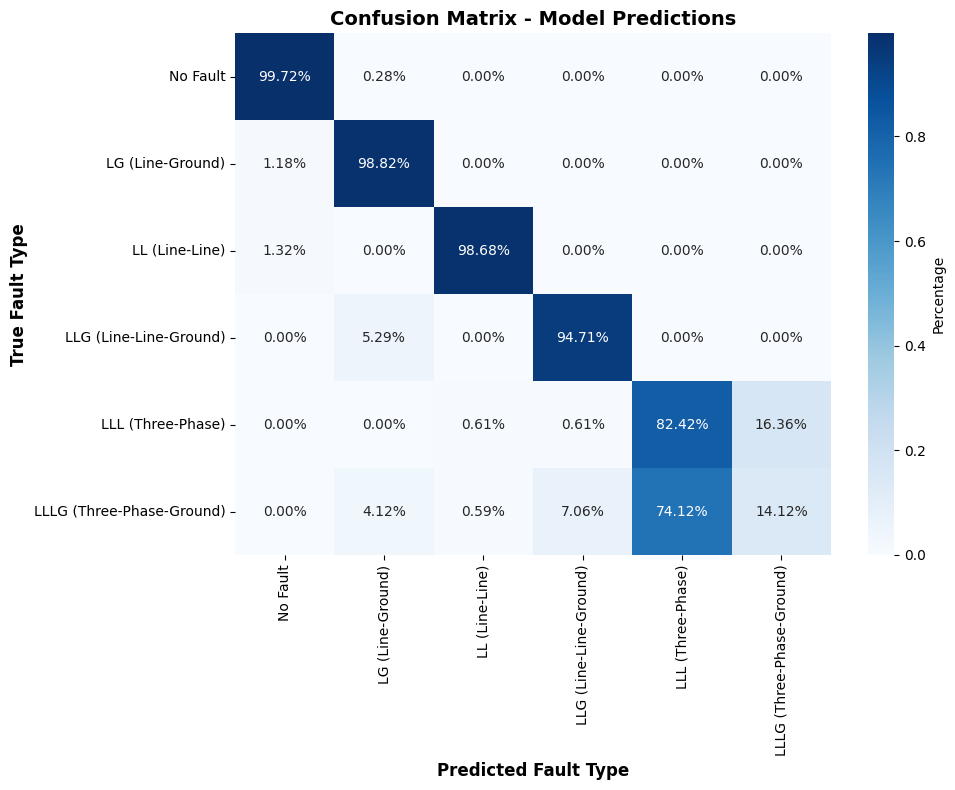

In [ ]:
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Plot 1: Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
print(" Saved: training_history.png")

# Plot 2: Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize confusion matrix (show percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=[fault_names[i] for i in range(num_classes)],
            yticklabels=[fault_names[i] for i in range(num_classes)],
            cbar_kws={'label': 'Percentage'})

plt.xlabel('Predicted Fault Type', fontsize=12, fontweight='bold')
plt.ylabel('True Fault Type', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Model Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print(" Saved: confusion_matrix.png")

plt.show()


In [ ]:
#Saving Model

print("SAVING MODEL")

# Save final model
model.save('fault_classifier_final.keras')
print(" Saved: fault_classifier_final.keras")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print(" Saved: training_history.csv")



SAVING MODEL
 Saved: fault_classifier_final.keras
 Saved: training_history.csv


In [ ]:

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)

print(f"\n Final Results:")
print(f"  Model Type: Deep Neural network")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
print(f"  Training Epochs: {len(history.history['loss'])}")
print(f"  Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")

print(f"\n Files Created:")
print(f"  1. best_model.keras (best performing model)")
print(f"  2. fault_classifier_final.keras (final model)")
print(f"  3. training_history.png (accuracy/loss plots)")
print(f"  4. confusion_matrix.png (prediction analysis)")
print(f"  5. training_history.csv (detailed training log)")

print(f"\n Next Steps:")
print(f"  1. Check confusion_matrix.png to see which faults are confused")
print(f"  2. If accuracy is low, try MODEL_TYPE='deep' for more capacity")
print(f"  3. Use the model for predictions on new data")

print("\n" + "="*70)


TRAINING COMPLETE

 Final Results:
  Model Type: Deep Neural network
  Test Accuracy: 83.98%
  Training Epochs: 32
  Best Val Accuracy: 84.61%

 Files Created:
  1. best_model.keras (best performing model)
  2. fault_classifier_final.keras (final model)
  3. training_history.png (accuracy/loss plots)
  4. confusion_matrix.png (prediction analysis)
  5. training_history.csv (detailed training log)

 Next Steps:
  1. Check confusion_matrix.png to see which faults are confused
  2. If accuracy is low, try MODEL_TYPE='deep' for more capacity
  3. Use the model for predictions on new data



In [ ]:
#Testing out model

print("\n Enter sensor readings (or press Enter to skip):")

Ia = float(input("  Ia (Current Phase A): "))
Ib = float(input("  Ib (Current Phase B): "))
Ic = float(input("  Ic (Current Phase C): "))
Va = float(input("  Va (Voltage Phase A): "))
Vb = float(input("  Vb (Voltage Phase B): "))
Vc = float(input("  Vc (Voltage Phase C): "))
powerData = np.array([[Ia, Ib, Ic, Va, Vb, Vc]])

model = load_model("fault_classifier_final.keras")

with open("dataset_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

scaler = metadata["scaler"]
fault_names = metadata["fault_names"]
#Normalize the input
sample_scaled = scaler.transform(powerData)
prediction = model.predict(sample_scaled)
print(prediction)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)

print("Predicted fault:", fault_names[predicted_class])
print("Confidence:", confidence)





 Enter sensor readings (or press Enter to skip):
  Ia (Current Phase A): -502
  Ib (Current Phase B): -174
  Ic (Current Phase C): -80.92
  Va (Voltage Phase A): 0.265
  Vb (Voltage Phase B): -0.11
  Vc (Voltage Phase C): -0.15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
[[4.9849640e-04 9.8177290e-01 3.1212858e-07 1.7399758e-02 1.1347126e-05
  3.1711758e-04]]
Predicted fault: LG (Line-Ground)
Confidence: 0.9817729
